In [ ]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import pandas as pd
from itertools import islice
import torch
from torch.utils.data import DataLoader
from utils.text_metrics import evaluate_all_metrics, save_metrics_to_json
from utils.train_comparison import *
from utils.processing import image_transform
from utils.models.lstm_models import DinoLSTMAttnCaptioner
from utils.data.chexpert_dataset import CheXpertDataset
from utils.data.padchest_dataset import PadChestGRDataset

# Data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CSV_PATH = "datasets/CheXpertPlus/df_chexpert_plus_240401.csv"
IMG_ROOT = "datasets/CheXpertPlus/PNG"

TEXT_COL = "section_impression"
PATH_COL = "path_to_image"

IMG_SIZE = 224
MAX_LEN = 64
NUM_BATCH = 8

tf = image_transform(img_size=IMG_SIZE)

ds_train = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="train", transform=tf, text_col=TEXT_COL)
ds_valid = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="valid", transform=tf, text_col=TEXT_COL)
ds_test = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="test", transform=tf, text_col=TEXT_COL)

tokenizer = build_tokenizer_from_labels()
pad_id = tokenizer.pad_token_id
eos_id = tokenizer.eos_token_id
bos_id = tokenizer.bos_token_id
collate_fn = CaptionCollate(tokenizer, pad_id)

train_loader = DataLoader(ds_train, batch_size=NUM_BATCH, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(ds_valid, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(ds_test, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)

Using device: cuda
[INFO] Kept 47494/223462 rows with existing PNGs
[INFO] Kept 47494/223462 rows with existing PNGs
[INFO] Kept 47494/223462 rows with existing PNGs


# Model

In [3]:
# DINO ViT-S/16 hidden size is 384 
EMBEDDING_D_IMG = 384
N_PREFIX = (IMG_SIZE // 16) ** 2  # number of visual prefix tokens (including CLS)

model = DinoLSTMAttnCaptioner(
    vocab_size=tokenizer.vocab_size,
    d_img=EMBEDDING_D_IMG,
    d_h=512,
    pad_id=pad_id,
    dino_model_id="facebook/dinov3-vits16-pretrain-lvd1689m",
    freeze_dino=True,
).to(device)

# Train Parameters

In [4]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-2
)
loss = sequence_ce_loss
NUM_EPOCHS = 30
BATCHES_PER_EPOCH = 10

# Training

In [5]:
import time
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    slice_train_loader = islice(train_loader, BATCHES_PER_EPOCH)
    slice_valid_loader = islice(valid_loader, BATCHES_PER_EPOCH)
    train_stats = train_one_epoch(model, slice_train_loader, optimizer, device, pad_id, num_batches=BATCHES_PER_EPOCH, loss_fn=loss, grad_clip=1.0)
    val_stats = evaluate(model, slice_valid_loader, device, pad_id, num_batches=BATCHES_PER_EPOCH, loss_fn=loss)
    print(f"Epoch {epoch + 1}: Train Loss={train_stats['loss']:.4f}, PPL={train_stats['ppl']:.2f} | "
            f"Val Loss={val_stats['val_loss']:.4f}, Val PPL={val_stats['val_ppl']:.2f}")
training_time = time.time() - time_start

Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Epoch 1: Train Loss=10.4066, PPL=38339.87 | Val Loss=9.3979, Val PPL=12140.86


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Epoch 2: Train Loss=8.7465, PPL=7092.30 | Val Loss=7.7899, Val PPL=2460.13


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Epoch 3: Train Loss=7.3527, PPL=1756.19 | Val Loss=6.8316, Val PPL=956.87


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Epoch 4: Train Loss=6.7194, PPL=862.29 | Val Loss=6.3977, Val PPL=627.25


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Epoch 5: Train Loss=6.3198, PPL=576.11 | Val Loss=6.1152, Val PPL=477.43


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch 6: Train Loss=6.1339, PPL=465.64 | Val Loss=5.8666, Val PPL=376.67


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Epoch 7: Train Loss=5.9013, PPL=387.82 | Val Loss=5.6946, Val PPL=318.63


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Epoch 8: Train Loss=5.6871, PPL=299.06 | Val Loss=5.5350, Val PPL=274.59


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Epoch 9: Train Loss=5.6434, PPL=299.95 | Val Loss=5.4375, Val PPL=249.25


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch 10: Train Loss=5.6124, PPL=282.53 | Val Loss=5.3340, Val PPL=224.21


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Epoch 11: Train Loss=5.4163, PPL=237.78 | Val Loss=5.2626, Val PPL=208.11


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


Epoch 12: Train Loss=5.4039, PPL=239.11 | Val Loss=5.1985, Val PPL=195.11


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


Epoch 13: Train Loss=5.2661, PPL=206.67 | Val Loss=5.1531, Val PPL=186.58


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


Epoch 14: Train Loss=5.2269, PPL=192.44 | Val Loss=5.1084, Val PPL=178.09


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch 15: Train Loss=5.3299, PPL=218.59 | Val Loss=5.0620, Val PPL=169.85


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


Epoch 16: Train Loss=5.0565, PPL=163.64 | Val Loss=5.0144, Val PPL=161.17


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


Epoch 17: Train Loss=5.1279, PPL=184.53 | Val Loss=4.9877, Val PPL=157.21


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch 18: Train Loss=5.0773, PPL=168.08 | Val Loss=4.9526, Val PPL=151.18


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


Epoch 19: Train Loss=4.9527, PPL=143.96 | Val Loss=4.9335, Val PPL=147.58


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Epoch 20: Train Loss=5.0516, PPL=164.02 | Val Loss=4.8969, Val PPL=142.41


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Epoch 21: Train Loss=5.0610, PPL=163.87 | Val Loss=4.8762, Val PPL=139.13


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Epoch 22: Train Loss=4.9866, PPL=150.22 | Val Loss=4.8716, Val PPL=138.21


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


Epoch 23: Train Loss=4.8394, PPL=130.76 | Val Loss=4.8706, Val PPL=138.17


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Epoch 24: Train Loss=4.9567, PPL=147.59 | Val Loss=4.8360, Val PPL=133.60


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch 25: Train Loss=4.9260, PPL=143.20 | Val Loss=4.8120, Val PPL=130.16


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch 26: Train Loss=4.9994, PPL=153.54 | Val Loss=4.7970, Val PPL=128.04


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch 27: Train Loss=4.8651, PPL=133.27 | Val Loss=4.7725, Val PPL=124.89


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


Epoch 28: Train Loss=4.9258, PPL=138.67 | Val Loss=4.7570, Val PPL=122.86


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Epoch 29: Train Loss=4.9336, PPL=145.73 | Val Loss=4.7438, Val PPL=121.15


Evaluating: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

Epoch 30: Train Loss=4.8139, PPL=125.24 | Val Loss=4.7252, Val PPL=119.07


# Test Parameters

In [6]:
BATCHES_PER_TEST = 1
GREEDY_DECODE = True
TEST_MAX_LEN = 256
TEST_TOP_P = 0.9
TEST_TEMPERATURE = 0.9

# Test

In [7]:
slice_test_loader = islice(test_loader, BATCHES_PER_TEST)
test_stats = evaluate(model, slice_test_loader, device, pad_id, num_batches=BATCHES_PER_TEST)
print(f"Test Loss={test_stats['val_loss']:.4f}, Test PPL={test_stats['val_ppl']:.2f}")

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

Test Loss=4.5662, Test PPL=96.18


# Test Report Generation

In [8]:
from utils.text_metrics import evaluate_all_metrics, save_metrics_to_json
text_generated = []
text_target = []
iteration = 0
with torch.no_grad():
    for pixel_values, ids_loader, paths, raw_labels in test_loader:
        iteration += 1
        pixel_values = pixel_values.to(device)
        # gen_ids = model.generate(
        #     pixel_values=pixel_values,
        #     bos_id=bos_id, eos_id=eos_id,
        #     max_new_tokens=TEST_MAX_LEN, top_p=TEST_TOP_P, temperature=TEST_TEMPERATURE, greedy=GREEDY_DECODE
        # )

        info = model.generate_with_logging(
            pixel_values=pixel_values,             # [B, C, H, W]
            bos_id=tokenizer.bos_token_id,
            eos_id=tokenizer.eos_token_id,
            tokenizer=tokenizer,
            preset="safe_sample",
            stop_sequences=["\n\n", "Impression:"],
            max_new_tokens=128,
        )
        # print("sequences:", info["sequences"].shape)
        # for i, s in enumerate(info["per_sample"]):
        #     print(f"[{i}] EOS={s['stopping']['hit_eos']} rep={s['repetition']}")
        #     print(s["text"].get("generated", "")[:200])
        
        text_generated.extend([s["text"]["generated"] for s in info["per_sample"]])
        text_target.extend(raw_labels)

        # eval_results = evaluate_all_metrics(raw_labels, [s["text"]["generated"] for s in info["per_sample"]], evaluation_mode="CheXagent")
        # for metric, scores in eval_results.items():
        #     print(f"{metric}: {scores}")

        # save_metrics_to_json(eval_results, f"lstm-vs-gpt/results/lstm_model_results_{NUM_EPOCHS}_Chexpert.json")

        # print("Predictions (first batch):")
        # for i in range(gen_ids.size(0)):
        #     text_gen = tokenizer.decode(gen_ids[i].tolist())
        #     text_tgt = tokenizer.decode(ids_loader[i].tolist())
        #     print(f"\nGEN {i+1}:", text_gen)
        #     print(f"TGT {i+1}:", text_tgt)
        #     results = evaluate_all_metrics([text_tgt], [text_gen], evaluation_mode="CheXagent")
        #     for metric, scores in results.items():
        #         print(f"{metric}: {scores}")
        # del pixel_values, ids_loader, paths, raw_labels, info
        # torch.cuda.empty_cache()
        if iteration >= 1:  # Limit to 1 batch for quick testing
            break

eval_results = evaluate_all_metrics(text_generated, text_target, evaluation_mode="CheXagent")
for metric, scores in eval_results.items():
    print(f"{metric}: {scores}")
eval_results["training_time_seconds"] = training_time
save_metrics_to_json(eval_results, f"lstm-vs-gpt/results/lstm_model_results_{NUM_EPOCHS}_Chexpert.json")

Using device: cuda:0
chexbert_f1_weighted: 0.4107142857142857
chexbert_f1_micro: 0.43478260869565216
chexbert_f1_macro: 0.14999999999999997
chexbert_f1_micro_5: 0.38095238095238093
chexbert_f1_macro_5: 0.18666666666666668
radgraph_f1_RG_E: 0.10575439895292835
radgraph_f1_RG_ER: 0.09509520024225906


In [9]:
paths[0]

'c:\\Users\\emman\\Desktop\\PROYECTOS_VS_CODE\\PRUEBAS_DE_PYTHON\\Chest-X-ray-Diagnosis-Automated-Reporting-using-CNNs-and-LLMs---UDEM-PEF-Thesis-Fall-2025\\datasets\\CheXpertPlus\\PNG\\train/patient37893/study7/view1_frontal.png'

In [10]:
text_generated[0]

'no significant interval change. persistent bilateral pleural effusions.'

In [11]:
text_target[0]

'interval placement of a right internal jugular venous sheath with the distal tip in the proximal superior vena cava. no pneumothorax. stable position of nasogastric tube feeding tube tracheostomy canula left internal jugular central venous catheter and left upper extremity picc. no significant interval change in hyperexpanded lung volumes right basilar opacities small bilateral pleural effusions tenting of the right hemidiaphragm and biapical pleural thickening.'

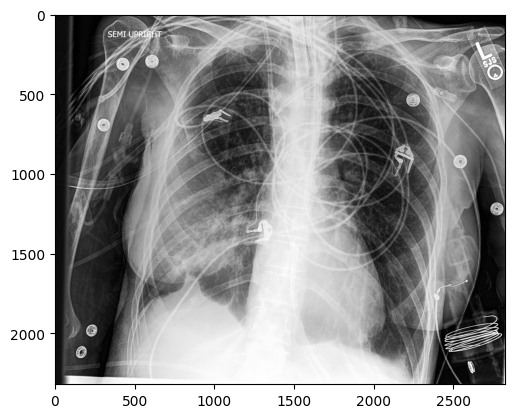

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(paths[0]).convert("RGB")
plt.imshow(img)